In [1]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '../src')

In [2]:
import jax
from jax import numpy as jnp
import json
import jax.random as jr
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats 
import discovery as ds
import discovery.flow as fw
from flowjax.distributions import Normal
import flowjax
import optax 
import corner
import pandas as pd
import math
import os
import equinox as eqx
jax.config.update('jax_enable_x64', True)

from flowjax.bijections import RationalQuadraticSpline, Affine
from flowjax.distributions import StandardNormal, Transformed
from flowjax.flows import masked_autoregressive_flow
from flowjax.train import fit_to_key_based_loss
from flowjax.train.losses import ElboLoss

import flowjax.bijections as bij

import discovery.EPTA as epta
import discovery.serialisation as serial

## CURN and HD

Load the pulsars and build the CURN and HD model

In [3]:
#all pulsars
psrfiles = os.listdir('../data/EPTA_feather_new/')
d_psrs = [ds.Pulsar.read_feather('../data/EPTA_feather_new/' + f'{psrfile}') for psrfile in psrfiles]

crn_model = epta.makemodel_curn_EPTA(d_psrs)
hd_model = epta.makemodel_hd_EPTA(d_psrs)

Pulsar.read_feather: cannot find dmx in feather file ../data/EPTA_feather_new/J0751+1807.
Pulsar.read_feather: cannot find dmx in feather file ../data/EPTA_feather_new/J1843-1113.
Pulsar.read_feather: cannot find dmx in feather file ../data/EPTA_feather_new/J1024-0719.
Pulsar.read_feather: cannot find dmx in feather file ../data/EPTA_feather_new/J1455-3330.
Pulsar.read_feather: cannot find dmx in feather file ../data/EPTA_feather_new/J0900-3144.
Pulsar.read_feather: cannot find dmx in feather file ../data/EPTA_feather_new/J1744-1134.
Pulsar.read_feather: cannot find dmx in feather file ../data/EPTA_feather_new/J1909-3744.
Pulsar.read_feather: cannot find dmx in feather file ../data/EPTA_feather_new/J1640+2224.
Pulsar.read_feather: cannot find dmx in feather file ../data/EPTA_feather_new/J2124-3358.
Pulsar.read_feather: cannot find dmx in feather file ../data/EPTA_feather_new/J1713+0747.
Pulsar.read_feather: cannot find dmx in feather file ../data/EPTA_feather_new/J2322+2057.
Pulsar.rea

Transform the likelihood and build the model with deafult options

In [5]:
transformed_logL_crn = ds.makelogtransform_uniform(crn_model.logL, ds.priordict_standard)
jlogl_crn = jax.jit(transformed_logL_crn)

hyperparams = {'n_samples': 512, 'knots': 8, 'interval': 5, 'patience': 100, 'multibatch': 1, 'LR': 1e-3, 'steps': 4000, 'flow_lay': 8, 'deepness': 1}
flow_final_crn = serial.make(key=jr.PRNGKey(1), loglike = crn_model, **hyperparams)


In [6]:
transformed_logL_hd = ds.makelogtransform_uniform(hd_model.logL, ds.priordict_standard)
jlogl_hd = jax.jit(transformed_logL_hd)

hyperparams = {'n_samples': 512, 'knots': 8, 'interval': 5, 'patience': 100, 'multibatch': 1, 'LR': 1e-3, 'steps': 4000, 'flow_lay': 8, 'deepness': 1}
flow_final_hd = serial.make(key=jr.PRNGKey(1), loglike = hd_model, **hyperparams)

Run the flow for both CURN and HD models and save the trained flows

In [ ]:
# Run the flow
out_flow = fw.VariationalFit(dist = flow_final_crn, learning_rate=hyperparams['LR'], loss_fn = fw.ElboLoss(jlogl_crn, num_samples=hyperparams['n_samples']), multibatch = hyperparams['multibatch'], show_progress = True, patience = hyperparams['patience'])
key, flw_params_crn = out_flow.run(jax.random.key(1), steps = hyperparams['steps'])

# Save the parameters
serial.save("CURN_EPTA.eqx", hyperparams, flw_params_crn)

In [ ]:
# Run the flow
out_flow = fw.VariationalFit(dist = flow_final_hd, learning_rate=hyperparams['LR'], loss_fn = fw.ElboLoss(jlogl_hd, num_samples=hyperparams['n_samples']), multibatch = hyperparams['multibatch'], show_progress = True, patience = hyperparams['patience'])
key, flw_params_hd = out_flow.run(jax.random.key(1), steps = hyperparams['steps'])

# Save the parameters
serial.save("HD_EPTA.eqx", hyperparams, flw_params_hd)

Load the trained Flow with the default configuration and take same samples

In [ ]:
flowmodel_crn = serial.load('EPTA_example_files/CURN_EPTA.eqx', loglike = crn_model)
samples_crn = flowmodel_crn.sample(jax.random.key(42), (10000,))
par_space_crn = jlogl_crn.to_df(samples_crn)

{'n_samples': 512, 'knots': 8, 'interval': 5, 'patience': 100, 'multibatch': 1, 'LR': 0.001, 'steps': 2000}


In [ ]:
flowmodel_hd = serial.load('EPTA_example_files/HD_EPTA.eqx', loglike = hd_model)
samples_hd = flowmodel_hd.sample(jax.random.key(42), (10000,))
par_space_hd = jlogl_hd.to_df(samples_hd)

{'n_samples': 512, 'knots': 8, 'interval': 5, 'patience': 100, 'multibatch': 1, 'LR': 0.001, 'steps': 5000}


## Enterprise Comparison

Load the chains of CRUN and HD analysis made with enterprise and compare the posteriors

In [12]:
chain = np.genfromtxt(f"EPTA_example_files/ptmcmc_CURN_EPTA/chain_1.txt")
names = np.loadtxt(f"EPTA_example_files/ptmcmc_CURN_EPTA/pars.txt",dtype=str)
chain = np.delete(chain,[chain.shape[1]-1,chain.shape[1]-2,chain.shape[1]-3,chain.shape[1]-4],1)
burn = int(0.25 * chain.shape[0])

burned_crn = chain[burn:, :]
chain_crn = pd.DataFrame(burned_crn, columns = names)

chain = np.genfromtxt(f"EPTA_example_files/ptmcmc_HD/chain_1.txt")
names = np.loadtxt(f"EPTA_example_files/ptmcmc_HD/pars.txt",dtype=str)
chain = np.delete(chain,[chain.shape[1]-1,chain.shape[1]-2,chain.shape[1]-3,chain.shape[1]-4],1)
burn = int(0.25 * chain.shape[0])

burned_HD = chain[burn:, :]
chain_HD = pd.DataFrame(burned_HD, columns = names)

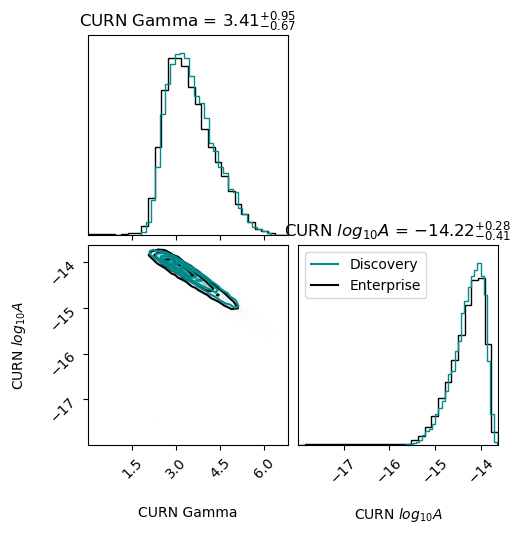

In [21]:
figsim = corner.corner(chain_crn[['gw_crn_gamma', 'gw_crn_log10_A']], bins=30, color='black', show_titles=1, labels = ['CURN Gamma', r'CURN $log_{10}A$'], hist_kwargs={'density': True}, plot_datapoints=False)
corner.corner(par_space_crn[['gw_crn_gamma', 'gw_crn_log10_A']], bins=30, color='darkcyan', show_titles=1, labels = ['CURN Gamma', r'CURN $log_{10}A$'], fig = figsim, hist_kwargs={'density': True}, plot_datapoints=False);

plt.plot([],[], c = 'darkcyan', label = 'Discovery')
plt.plot([],[], c = 'black', label = 'Enterprise')
plt.legend()

plt.show()

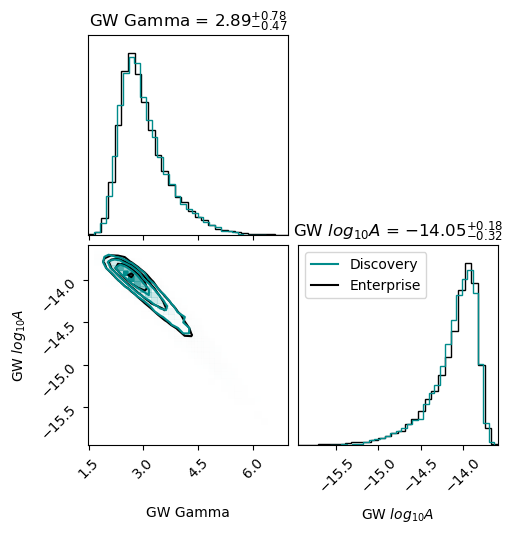

In [22]:
figsim2 = corner.corner(chain_HD[['gw_hd_gamma', 'gw_hd_log10_A']], bins=30, color='black', show_titles=1, labels = ['GW Gamma', r'GW $log_{10}A$'], hist_kwargs={'density': True}, plot_datapoints=False)
corner.corner(par_space_hd[['gw_hd_gamma', 'gw_hd_log10_A']], bins=30, color='darkcyan', show_titles=1, labels = ['GW Gamma', r'GW $log_{10}A$'], fig = figsim2, hist_kwargs={'density': True}, plot_datapoints=False);

plt.plot([],[], c = 'darkcyan', label = 'Discovery')
plt.plot([],[], c = 'black', label = 'Enterprise')
plt.legend()

plt.show()

Compute the Hellinger distance 

In [23]:
print('CURN: ', fw.hellinger(par_space_crn, burned_crn))
print('HD: ', fw.hellinger(par_space_hd, burned_HD))

CURN:  0.0006049897143769467
HD:  0.00027517881673277955
